# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [57]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
#added countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [58]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [115]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False)
        #cv = CountVectorizer()
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
       # print("Shape of HashingVectorizer X:")
        print("Shape of CountVectorizer x: ")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    # should it be a boolean value? As str.find returns an index; how will a boolean be converted to 0 or 1
    toxic_data['occur_fuck'] =(toxic_data['comment_text'].str.lower().str.count("fuck"))
    toxic_data['occur_shit'] =(toxic_data['comment_text'].str.lower().str.count("shit"))
    toxic_data['uppercase_letters'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    

    X_quant_features = toxic_data[["word_count", "occur_fuck", "uppercase_letters", "punc_count", "occur_shit"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [116]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=65)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [117]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 6622, 'TN': 55042, 'FP': 59543, 'FN': 6449, 'Accuracy': 0.4830481920160431, 'Precision': 0.1000831255195345, 'Recall': 0.506617703312677, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [118]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12074, 'TN': 113717, 'FP': 868, 'FN': 997, 'Accuracy': 0.9853904242652127, 'Precision': 0.932931540720136, 'Recall': 0.9237242751128453, 'desc': 'svm_train'}


### MODEL: logistic regression

In [119]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12367, 'TN': 114006, 'FP': 579, 'FN': 704, 'Accuracy': 0.9899495519207872, 'Precision': 0.9552757608527731, 'Recall': 0.9461403106112769, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [120]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 11958, 'TN': 99754, 'FP': 14831, 'FN': 1113, 'Accuracy': 0.8751018361847465, 'Precision': 0.4463772443913547, 'Recall': 0.9148496672022034, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [121]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12281, 'TN': 113505, 'FP': 1080, 'FN': 790, 'Accuracy': 0.9853512565018487, 'Precision': 0.9191677269665445, 'Recall': 0.9395608599189045, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [122]:
from sklearn import linear_model
#try small numbers 0.1 or something
#try multiple ridge models
rdg01 = linear_model.RidgeClassifier()
rdg01.fit(X_train, y_train)

rdg01_performance_train = BinaryClassificationPerformance(rdg01.predict(X_train), y_train, 'rdg01_train')
rdg01_performance_train.compute_measures()
print(rdg01_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 8347, 'TN': 114183, 'FP': 402, 'FN': 4724, 'Accuracy': 0.9598452089991854, 'Precision': 0.9540518916447595, 'Recall': 0.6385892433631704, 'desc': 'rdg01_train'}


In [123]:

#try small numbers 0.1 or something
#try multiple ridge models
rdg02 = linear_model.RidgeClassifier(alpha=0.034)
rdg02.fit(X_train, y_train)

rdg02_performance_train = BinaryClassificationPerformance(rdg02.predict(X_train), y_train, 'rdg02_train')
rdg02_performance_train.compute_measures()
print(rdg02_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 8347, 'TN': 114183, 'FP': 402, 'FN': 4724, 'Accuracy': 0.9598452089991854, 'Precision': 0.9540518916447595, 'Recall': 0.6385892433631704, 'desc': 'rdg02_train'}


In [124]:

rdg03 = linear_model.RidgeClassifier(alpha=0.15)
rdg03.fit(X_train, y_train)

rdg03_performance_train = BinaryClassificationPerformance(rdg03.predict(X_train), y_train, 'rdg03_train')
rdg03_performance_train.compute_measures()
print(rdg03_performance_train.performance_measures)


{'Pos': 13071, 'Neg': 114585, 'TP': 8347, 'TN': 114183, 'FP': 402, 'FN': 4724, 'Accuracy': 0.9598452089991854, 'Precision': 0.9540518916447595, 'Recall': 0.6385892433631704, 'desc': 'rdg03_train'}


In [125]:

rdg04 = linear_model.RidgeClassifier(alpha=0.35)
rdg04.fit(X_train, y_train)

rdg04_performance_train = BinaryClassificationPerformance(rdg04.predict(X_train), y_train, 'rdg04_train')
rdg04_performance_train.compute_measures()
print(rdg04_performance_train.performance_measures)



{'Pos': 13071, 'Neg': 114585, 'TP': 8347, 'TN': 114183, 'FP': 402, 'FN': 4724, 'Accuracy': 0.9598452089991854, 'Precision': 0.9540518916447595, 'Recall': 0.6385892433631704, 'desc': 'rdg04_train'}


In [126]:

rdg05 = linear_model.RidgeClassifier(alpha=1.25)
rdg05.fit(X_train, y_train)

rdg05_performance_train = BinaryClassificationPerformance(rdg04.predict(X_train), y_train, 'rdg05_train')
rdg05_performance_train.compute_measures()
print(rdg05_performance_train.performance_measures)



{'Pos': 13071, 'Neg': 114585, 'TP': 8347, 'TN': 114183, 'FP': 402, 'FN': 4724, 'Accuracy': 0.9598452089991854, 'Precision': 0.9540518916447595, 'Recall': 0.6385892433631704, 'desc': 'rdg05_train'}


### MODEL: Random Forest Classifier

In [127]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 0, 'TN': 114585, 'FP': 0, 'FN': 13071, 'Accuracy': 0.8976076330137244, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\jills\Documents\Machine Learning\ml\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

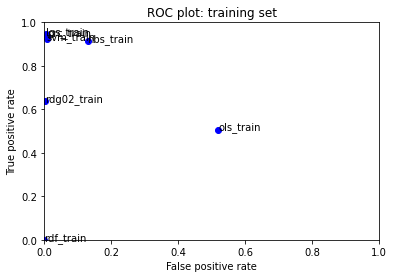

In [128]:
#fits = [rdg01_performance_train,rdg02_performance_train,rdg03_performance_train,rdg04_performance_train,rdg05_performance_train]
fits = [rdf_performance_train,rdg02_performance_train,prc_performance_train,nbs_performance_train,lgs_performance_train,svm_performance_train,ols_performance_train]
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [129]:
ols_predictions = ols.predict(X_train)

In [130]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
39
Editing articles

To make a new section type ==Name of section==. For a subsection use ===Name of subsection===. Let me know if you have any questions.
* * * * * * * * * 
42
"
Support. I'm embarrassed to admit that I've watchlisted this page for some time, and was never aware of the error in the name. However, comparing Google Book searches for each spelling of the name –  and  – makes it clear that ""Anna"" is correct.   "
* * * * * * * * * 
61
A Lou Dobbs had allegedly made those comments of rebellion.
* * * * * * * * * 
112
"
As long as you have the support of 51% of the people your going alright. Aaroncrick(Tassie Boy talk) "
* * * * * * * * * 
210
Youth 

Does anyone else agree that the youth of Didcot, namely the chavs, are creating a serious problem in Didcot? Until recently, it seemed as if everything was calming down...but now, there are stabbings and everything occuring.

Is it just the chavs to blame, or is it the youth population as a whole?


4406
And, by the way, stop writing that Frau Rathlef moved her to a better hospital, that was a decision taken by Zahle, Mr. and Mrs.Gilliard and Rathlef together, and the Prince of Denmark paid the bill.
* * * * * * * * * 
4462
In that case, feel free to revert to my original edit then.  I do not have a strong personal preference between the two variations.  My second variation was an attempt to address the concern of others.   19:52, 8 Apr 2005 (UTC)
* * * * * * * * * 
4535
It's true: it does happen.
* * * * * * * * * 
4567
Me speaks of life in a broader sense. as I am not interested in yours, per se (such arrogance you have to assume such). I am interested in keeping you out of my life and leaving my history to the experts.     Whistlersghost
* * * * * * * * * 
4572
Netherlands section
I recently reverted an edit that drastically expanded discussion of the KNMG statement, thus creating undue weight issues.  Please note that the present summary is a result of extensive discussion and

8776
Nobody needs to write a 500 page report it can be quantum-style, summed up in about, I don't know I need a number crunch here: 10-26 if you're the best.
* * * * * * * * * 
8886
List of University of Minnesota people
* * * * * * * * * 
9060
They are still in orbits. just not earth orbit. leave as is.
* * * * * * * * * 
9148
"

Chillum. In a fair project, what you said would be completely true.  But, the project stinks of Bishonen's rancid smell. As I said in my valid and now removed comment, Bishonen's few asses always rush to cover up her shit, like Dr. Michel just did. He removed my comment and blocked me from making more comments.  So, do you really want me to allow Bishonen, Drmies et al to do the same to my regular admin account knowing what they get away with on here?  No, I don't think so.  There are billions of IP's for us to throw away and make our points.  I only have one account here. By the way, many editors are now using throw away IP's.  The project's culture not them

Where is the proof, or even the evidence, that any of this is true?
* * * * * * * * * 
12248
, 25 August 2005 (UTC)

Disagreement is when you talk about the content of what is written, regardless of its source. Prejudice is when you personalise it.  12:11
* * * * * * * * * 
12305
On second thoughts, I think we may both be barking up the wrong tree here. This section should be about Sahaja Yoga beliefs rather than what actually happened or what is reported to have happened in reliable sources. If possible, we should base the section on 3rd party reliable sources about what Sahaja Yogis believe, and we only really have Coney. I'll try and look up what she says on this matter.
* * * * * * * * * 
12358
Deleted that copyvio page and moved Iraqna to Zain Iraq.
* * * * * * * * * 
12405
The nerve of the man, gotta hand it to him!
* * * * * * * * * 
12433
"

 DYK 

On June 10, Did you know? was updated with a fact from the article Europasaurus, which you created. If you know of another interest

14951
I just feel it's a bit over the top to ban me permanently for enthusiastically supporting someone. I have made absolutely no personal attacks, nor vandalized any articles.
* * * * * * * * * 
14968
"
Jasper Deng is faster than me... The same question. cat "
* * * * * * * * * 
15060
Well that's the best reason of all not to include it!  The page was empty when I was editing yesterday - along with others to the same site that this and related IPs added.  I guess there was a glitch on the site since they are all now showing content.  I don't understand your point number 2.  I wasn't claiming it was a references - the wikilink I provided was to our guidelines on external links, which this site falls foul of being a newish open wiki without substantial editing history from many contributors, and with no particular reputation on this subject.  We may not be great on all subjects, but that doesn't mean we should be expanding those issues by creating a big association of untrustworthy pag

17879
"

Let's just keep it until we straighten out certain things  • A • R • C • E • "
* * * * * * * * * 
17888
"
 She has always been billed from Denver from my memory. The people who are reverting it to LA are wrong, but we do need a video reference to back it up otherwise it will keep on being reverted. !! a Punk !! "
* * * * * * * * * 
17897
I've said once, i say it again - if you don like thugstep that's you bizness. If you think that quite a range of refenreces to web-pages stays it non-notable you are welcome to tell it to admin for it to be deleted.  82.209.225.33
* * * * * * * * * 
17904
Anglican Self-concept, Catholic or Protestant 

This has already been discussed but editing is still taking place on this issue. See the section above Protestantism-Anglicanism

This hidden note appears in the article:

It separated from the Roman Catholic Church in 1534 with the Act of Supremacy and understands itself to be both Catholic (universal) and Reformed (Protestant)http://www.cofe.a

20735
"
Because I wasn't curious at the time. Just recently, I got concerned. As a reminder, earlier you said ""Why the hell is it your business?"" which with its tone violates WP:CIVIL.  — (talk • contribs) "
* * * * * * * * * 
20762
"

The following people have conspired to edit war for the sake of inserting their POV thus violating NPOV and suppressing information.  See their conspiracy to edit war and, this is their words not mine ""call to arms"" here i.e. where they call for an edit war.  

"
* * * * * * * * * 
20763
accuracy of date of birth? other sources (http://www.parliament.nsw.gov.au/prod/parlment/members.nsf/0/a9da3ee47e344cd64a25672e0002e1b5) cite 1937
* * * * * * * * * 
20781
, 

I have again undone the reference to a crime from years ago that really has no relevance AT ALL to the school becoming a comprehensive in 1980. FFS! If you go to the page for any school on wikipedia, you will not find, generally speaking, references to crimes committed by pupils at the school t

25386
Fozzy w. + 2 yards 

In the game agains the giants fozzy rushed for two yards. Do you have those yards? And If not: I'm sorry.
* * * * * * * * * 
25444
Talkpage 

Please do not edit my talkpage.
* * * * * * * * * 
25457
Thank you, and request 

Thank you for the unblock. Again, I would like to ask you to monitor all of my activities and interactions with others, especially with those who brought and fought for the charges resulting in the indef block, with the purpose of giving me warning, instruction, and (in general) mentoring me along the way here at Wikipedia. I admire your fairness in contributing to the WP project, and would appreciate your assistance here.   Talk
* * * * * * * * * 
25490
"

Mitchell Awardees get E-3 in Air Force and E-2 in Army, Navy, and Marine Corps
Call a recruiter to be sure.  Ask about the 'Advance paygrade Enlistment Statement of Understanding"" and Navy Regulation: NAVCRUIT 1133.101 and you will see that this information is correct.  Despite the fac

28659
I'm sorry, Iridescent; I would hate to prove you wrong, but perhaps this or this will be good reading. I'm pretty sure that's the policy, but I could be wrong. Take a look at it, will you?
* * * * * * * * * 
28695
Avoid technical details in plot. 

Thank you for providing an explanation for your reversions of my changes to the plot section of Saving_Mr._Banks. Unfortunately, I do not understand how my edits had any more technical details than the text I changed. Let's start with the first sentence. I changed 
 Disney belatedly realizes that Travers is writing under a pen name; her real name is Helen Goff, and she’s actually Australian, not British.
to
 Just then, Disney learns that Travers is writing under a pen name.  Her real name is Helen Goff, and she’s actually Australian, not British. 
What technical detail does that change introduce?
* * * * * * * * * 
28712
"
Any sort of human interaction. Dropping depth charges. Trawling. Not like I can define all of them. Also, what do 

32511
"
I remember it happening during the summer of 2002. I think it would make a great addition to the section covering his Wrestlemania VI attendance and support of Hogan to show more of a ""full circle"" journey. 71.139.161.165  "
* * * * * * * * * 
32550
Hmm, no. Rather, I hope to highlight the citation of a series of non existent local clauses, as well as the criticism of the legitimate sources, which lead to the deletion of my article.
* * * * * * * * * 
32601
The flaws? What flaws? This is exactly the crux of my point. If anyone has reason to suspect there are flaws, they should address those instead of putting down boilerplates, which is a cop-out. It's a community effort to make this article work, but boilerplates do not constitute 'effort', they are like giving up and walking away. Spraypainting a tree 'this needs to be check for deadfall'. But it just makes the tree ugly, for no good reason. Same goes for this article.
* * * * * * * * * 
32667
I responded to this long diatr

35879
"
I believe some filty flesh on the pilot (i mean on the buffer )) of that   loco engine. Anyway proud to be  a Sri Lankan. Summon "
* * * * * * * * * 
35921
SPLC and ADL - Need to be cross-verified by other reliable sources 

after looking at this page [], I see that other editors are suggesting that since the ADL and SPLC have a 50% approval rating, it should be (though it isn't P ) required that their statements be confirmed by another trusted 3rd party publisher. Is this too much to ask? If so, could that be because there are no other reliable sources who have made claims such as the ones put forth by the SPLC and the ADL? If so, doesn't that mean they are ALL ALONE IN THEIR ASSERTIONS? If so, shouldn't they be considered self-publishing? If so, shouldn't they be removed from Wikipedia because they are making ridiculous claims?
* * * * * * * * * 
35947
"

Quick question

Indeed I did thanks. Looks a lot better than before I started doesn't it? 303 "
* * * * * * * * * 
35985
I

39590
"Eugenics was in any case a grotesque misuse of science (and promulgation of pseudoscience)... International Review of Psychiatry. ""The International Review of Psychiatry is the premier review journal in the field with a truly international authorship and readership. Each bimonthly issue is dedicated to a specific theme relevant to psychiatry, edited by recognized experts on the topic,"" - Routeledge: Taylor & Francis Journals Online 
 
"
* * * * * * * * * 
39598
"

 Please stop making unconstructive edits. If you continue to make those kind of edits, you will be blocked from editing. [[Special:Contributions/Inka 888|888]]Come yell at me! "
* * * * * * * * * 
39640
"

Someone had vandalized the page.  '''''' "
* * * * * * * * * 
39812
You make a good point.
* * * * * * * * * 
39820
"

[ WP:Edit conflict ]: Regarding sources, I stated, ""The sources don't seem to indicate simply 'prepubescent.'"" And ""that is just as much a WP:OR matter if there are no WP:Reliable sources out th

"

never mind, i saw the name calling section where you posted this same incident in a link. but it still is disturbing on how Arilang1234's current apology is worded in exactly the same way as his previous ""apology"".  "
* * * * * * * * * 
42870
Thank you Arbcom 

I wanted to wish you good luck with your new responsibility, use it well, use it wisely, and USE IT OFTEN. We need more active editors with check user rights, and honestly I cant think of a better person than yourself.  (T C)
* * * * * * * * * 
42892
"

If you blocked me because you think I am  is trying to frame me once again.…   03:05, September 13, 2005 (UTC)"
* * * * * * * * * 
42956
"

Please stop. If you continue to vandalize pages, as you did to William Shakespeare, you will be blocked from editing Wikipedia.   talk  "
* * * * * * * * * 
43060
"
 You may want to check out WP:SPA and WP:COI.  Talk "
* * * * * * * * * 
43112
WHere does Spooner attack wage labor vehemently?
* * * * * * * * * 
43253
":Jew Marxist Raus Ra

45757
7th Edition publication date?
Hi, any announcements or speculation when the Shorter 7th edition will be published and sold?  We could add a paragraph to the entry!  Thanks
* * * * * * * * * 
45822
{{unblock| Block not justified 

The block was not justified.

I had added new reference links to the Chamar & Ramdasia discussion page, responding to comments posted by other user asking for proofs.
The links provided are valid and include Official Constitution of India and books available on Google books.

The other user who has accused me of vandalism has so far not provided any reference links or material to back up his claims. He has constantly deleted my links and edits and then he accused me of being a vandal. 

I request that you see all the links I have provided and compare it to what the other user is contributing.

Also, I have not made any changes to the article and posted these in the article discussion page asking for the other users to respond.

Please explain the reason 

48076
, 16 December 2010 (UTC)
 Marseille is not an English form; it does not appear as a headword in the OED while Marseilles does.  This is not a mere personal opinion, as you misleading suggest, because the OED and Economist are excellent reliable sources.   21:56
* * * * * * * * * 
48117
>>>I second your non-ironic awe.   Excellent work.   Thanks.
* * * * * * * * * 
48169
"
Yeah, that paragraph is a mess. For starters, there was already a fascist regime in Italy before the Great Depression. I've done a provisional edit to that paragraph, including a wikilink to Weimar, etc., which is all I can do at present. 連絡 見学/迷惑 "
* * * * * * * * * 
48184
I agree that as we move away from the prelude, that stuff can be pared down more and more.
* * * * * * * * * 
48213
"

 deleted Fort PLank article 

 

I am the author of ""The Bloodied Mohawk"". I am the sole owner operator of www.fort-plank.com. All of the articles on My Website are copyrighted under my name and I am releasing my own copyri

51280
Listen Ho! 

YOU'RE A HO!
* * * * * * * * * 
51288
Very likely. I think it's a good deletion, and I'm not surprised that Doc did it. ) I would probably have deleted if I had not already been involved in protecting the article at the last space and if it were a little more clearly in vio of BLP. Like you, I didn't see it as speediable. (Even in google news, the name hits 11 right now. On the web, it's got 29,600. But I don't believe Wikipedia should be contributing to it, and I applaud you for ferreting it out to begin with and Doc for flushing it.  (talk)
* * * * * * * * * 
51400
Do you know the person named is a Police officer , You should delete that whole entry.
* * * * * * * * * 
51401
"
These links have not been discussed and they should.  If they're not included on this page then it should be removed completely as Justin Berry will likely want only his POV or those that parrot it.  It should also be noted that neither of these sites are ""pro-pedophilia"".  In fact, the ver

54520
Hopefully, it won't be challenged as unacceptable. Like as in the sun rises in the east and sets in the west .
* * * * * * * * * 
54531
"

Please read that policy more carefully: it states: ""Self-published and questionable sources may be used as sources of information about themselves, usually in articles about themselves or their activities"" (emphasis in original)  this is not information about Utiger, nor is it in an article specifically about him or his activities. It is you using Utiger to speak for all modern progressive creationists  which he is in no position to do. You should also read WP:UNDUE  as your addition gives undue weight to the views of an obscure figure. ''TalkStalk''(P) "
* * * * * * * * * 
54567
Who do you think you are.
* * * * * * * * * 
54659
Thanks for the heads-up, I'll try to to get around to solving the problems you raise this weekend.
* * * * * * * * * 
54680
"

 New AN/I: Gohar Shahi / Younus AlGohar 

Yet again, an Administrators' noticeboard/inci

56640
"

 Okay I checked it. It has a weak fair use rationale, but it might qualify, but it is very borderline. Rationale: will likely not impede commercial revenue; it is used for the critique or discourse about a famous person, it is for educational purposes, and it informs the public. Generally not preferred though. Resolution seems low enough.  (Be eudaimonic!) "
* * * * * * * * * 
56657
"

You don't know the clan of ""most of those people"" because that's what happens when people stick their nose in something they know nothing about.

1st row: 
Muhammad Abdullah Hassan - Darood
Fatima Jibrell - Darood 
Mohamed Abdullahi Mohamed - Darood
Asli Hassan Abade - Darood
2nd row: 
Hanan Ibrahim - Isaaq
Hadraawi - Isaaq
Iman - Darood 
Sultan Yusuf Ali Kenadid - Darood
Aar Maanta - Darood
Sultan Mohamoud Ali Shire - Darood
Osman Yusuf Kenadid - Darood
Nuruddin Farah - Darood

I hope you know now. Not a single Hawiye person—who have contributed to Somaia the most and are the most dominant cl

59976
HAVE A NICE DAY ! 90.209.140.180
* * * * * * * * * 
59983
DECEMBER 3rd, 2007 

 Please stop. If you continue to vandalize pages by deliberately introducing incorrect information,  you will be blocked from editing Wikipedia.
* * * * * * * * * 
59990
"

 New Illustated Discography Storage Link Needed 

Had to delete the illustrated discography BEBO link. The new change to large size advertising spam on BEBO has become ridiculously intrusive and irrelevant and the new ""exclusive"" conditions of use means the general public can no longer view the pics without becoming a signed up member. Anyone have any suggestions for a new online deposit site for McMahon related pics with something like the BEBO quality.  "
* * * * * * * * * 
60012
"
It's not only ""too long"" it's also an opinionated attack creation, this version was outrageous and should never have been published - https://en.wikipedia.org/w/index.php?title=Alessandra_Stanley&diff;=626918992&oldid;=626918428 - I agree with every

62997
constantly being harrassed 

Hi, Babbaq keeps giving problems and is taking this personal vendetta against someone that must live in my area out on everyone. I simply changed a word on the cheshire,ct page as we do not have a mayor and he/she keeps reverting and leaving all sorts of silly messages. If this is an encyclopedia, we should have our facts straight and we most certainly do not have a mayor. Thanks for any help you can provide.
* * * * * * * * * 
63031
"

 Please do not vandalize pages, as you did with this edit to The Tyra Banks Show. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
63043
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sig

66110
"

Harald88, you are mixing up everything again like an autodidact, and you don't want to listen. You know once again  everything in advance and much better than anybody else. What you are stating here, however, is nonsense again. The classical forerunner of SRT has been  optics of moving bodies, a discipline dealing with the observation of  point source from a moving platform, which is governed by Bradley's law of velocity aberration. A point source emits spherical waves, not plane waves.

In none of the references stated in the nonsensible Wikipedia article on the transverse Doppler effect, to which you have contributed, a proof is delivered, but it is simply asserted there that the transverse Doppler effect has been unknown in classical physics. In dozens of textbooks this nonsense is repeated without proof because authors tend to write off from one another.

'Proofs' of the nonsense are delivered in Chapter 11 of J. D. Jackson's book on clsssical electrodynamics as well as in

69647
"
Hello , I have started your  and have left there some tasks for you. Read the instructions on the page carefully and keep the page on your watchlist. Best, '''''' "
* * * * * * * * * 
69664
How am I supposed to edit and create new articles if its deleted before I can finished it?
* * * * * * * * * 
69728
REDIRECT User talk:Quizimodo (usurped)
* * * * * * * * * 
69729
The author of LotR clearly intended it to be a single book, and it was sold as one concurrently with the three-volume editions as soon as it became popular enough to be economically feasible.  The utilitarian separation of the book into three volumes does not seem to me to be sufficient reason to declare it to be three separate books.  This is in stark contrast with Rowling's books, which have been published sequentially, separated by years in between them, and are considered by everyone (including the author and publisher) to be separate books entirely.  I agree that the individual books deserve a place on this li

74054
, and if he's such an immature little prick that telling him I'm upset with him means that he'll kill two featured process's chances of being on the main page, I'll rot in hell before ever working with him again.
* * * * * * * * * 
74063
I also won the Master Nerd Prize but not see where the user box is for that.
* * * * * * * * * 
74085
Welcome!

Hello, Revjun, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page and How to develop articles
How to create your first article (using the Article Wizard if you wish)
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question on this page and then

76961
"
Thanks, I've added some other comments. Regards,    Chat   "
* * * * * * * * * 
77032
I think Super GM is inappropriate title for Wesley So.  Only GMs with rating of 2700 and above are considered Super GM.
* * * * * * * * * 
77170
I have to say I disagree a little bit on the Colorado and Michigan State games. Appalachian State definitely deserves mentioning, but Colorado and Michigan State, while both having great and interesting finishes, are not important enough to be mentioned in the header, particularly when you combine it with the absence of the 1945 Army game, and the 1969 and 2006 Ohio State-Michigan games, the '69 game in particular because Woody admitted that was his best team and the Wolverines cost the Buckeyes what would have surely been a national title since the Buckeyes were locked out of the Rose Bowl. If Colorado and Michigan State are worth mentioning, then so is 2010 Illinois and 2011 Notre Dame. Interesting, great games, but probably not worthy of being put 

79388
"

Another source:
AltHealth http://www.althealth.co.uk/services/info/misc/polyols.php
""Since polyols are only partially absorbed by the body, they have fewer calories than sugar. Polyols range from 0.2 to 3 calories per gram, compared to sugar with 4 calories per gram.""
For those who like to claim that the reason for some UK usage is that it comes from the United States, here is information on the owner of the site, a UK national (Wakefield, West Yorkshire, not Wakefield, Connecticut) who identifies the web designer as his son.  "
* * * * * * * * * 
79391
":::I didn't suggesting using the word. I'm suggesting adding mention of the upcoming interview without mentioning that word. The TV Guide story quotes Sawyer as saying that her interview with Jenner is ""a really compelling conversation about so many things, a broad look at life...It's about family and how we all live our lives."" Can't this be added, and then any more specific contents of the interview added after it airs? 

83203
you've highlighted that
* * * * * * * * * 
83214
I said a lot of times in the other articles. MHP or the Grey Wolves not a faschist organisation. It is origin is Türk Ocakları and they founded by Turkish intellectuals like Ziya Gökalp. And his origin is kurdish. MHP leaders says a lot of time they are in the opposite for faschism. They said faschism is a other form of imperialism and capitalism. They said racism is forbbiden in Islam. And MHP never accept a thing which forbidden in Islam. 

Gladio connection never be proved. Some communists authors(Soner Yalçın) claim that. But they cannot prove that, they say only all the anti-communist organizations are gladio. The general Kenan Evren who makes the military coup in 1980 said that Turkey rejects to build a Gladio. Bülent Ecevit is played an activ role in 1970's communist-nationalist crise and his words cannot be objective. Please show me exact sentences of these sources which menitoned in the article.
* * * * * * * * * 
83230
"


86019
Freemasonry - everything missing 

Everything about Freemasonry is completely missing. Sources:
 10,000 Famous Freemasons from K to Z from Harry S. Truman
 http://spokanecda.com/Masonic%20Temple.html
 http://www.spokanemasonictemple.org/History/History.htm
 http://www.srmason-sj.org/web/journal-files/Issues/sep-oct05/coop.html
 http://www.matinecock.org/portal/desktopdefault.aspx?tabindex=2&tabid;=23&item;=10

Some facts:
Masonic laying of the foundation stone:
 Army War College february 21, 1903
 Yellowstone Park (Grand lodge of Montana) april 24, 1903

 Masonic Temple, Tacoma, Washington May 22 1903
 Masonic Temple, Spokane, May 26, 1903
 Officebuilding of the House of Representatives April 14, 1906
 Masonic Temple 13. Str. and New York Ave. Wash. D.C., june 8, 1907 
 Pilgrim Memorial august 20, 1907

Speech to the Masonic Grand Lodge of Pennsylvania because of the 150th anniversary of the masonic raising of George Washington in 1902
 One of the things that attracted me so grea

88812
"

 Please do not vandalize pages, as you did with this edit to Fret. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
88820
as far as nicknames go this article is embarrassing, Where is the Human fish, golden fish, flying fish, and the American super fish, among others? wiki should be ashamed for this mess of an article. ~Anonymous *and there I signed the post*
* * * * * * * * * 
88834
what is wrong 

Dear pdcock, 

I don't understand why do you  want to block me!

I was just editing some pages. If you don't want me to do so, why you allow the edit of such pages? Is it a trick?
* * * * * * * * * 
88892
ECC & BCJR 

Unfortunate that there's no discussion, since the explanation of BCJR & viterbi, when applied in the digital domain, is considerably easier to understand than the HMM version given here.  Unfortunately, the BCJR article is currently a stub with no content in it -(  Anyway, just to make this article easier to understand, I think its i

91366
"

 Ok Vinod many thanks, great effort. The next item of business of the Project, focusing out of the Portal, would be to resolve some questions; the actions we take further on depends on it: could you point yourself here and contribute an ounce of your brain... Thanks,   "
* * * * * * * * * 
91440
karluk yagbu state  

can somebody write about karluk yagbu state.

http://e-history.kz/en/contents/view/309
* * * * * * * * * 
91551
Hello, Jeroje, and welcome to Wikipedia! I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
How to edit a page
Help pages
How to write a great article
Manual of Style
Also feel free to .
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, please leave me a message.
Category:WelcomeBotResearch
* * * * * * * * * 
91579
"

Peers of Ireland
Women who

94046
Stub tags
HI Morten. You may as well create the tags you proposed for 1740s and 1750s Norwegian politicians, seems there was a consensus for it.
* * * * * * * * * 
94047
Agreed, a test Ref Desk doesn't have to be perfect or complete.
* * * * * * * * * 
94077
What you are refering to as an autoflower is actually ruderalis which flowers like this normally crossed with an indica. The flowers these plants produce are high in cbd and very low in thc, you shouldent really grow these strains they are poor, autoflower is just a maketing term94.168.211.137
* * * * * * * * * 
94186
And just how hard can it be to type four tildas? I liked Wikipedia more when rednecks stuck to singing.
* * * * * * * * * 
94260
"

 See my expl 

WHY I remove it. ""Military build-up"" is Section 2 of the article. Besides, within its context, the news reports pasted are quite irrelevant. The person who did the initial edit adding those, apparently had not read the article.  "
* * * * * * * * * 
94292
"

All tha

96704
As much as me and you had a bad start and we had our difference, we finally stop quarreling each other and understand our own opinions on the Los Angeles Metro bus fleets of certain units that are important to know what happened to them and what's they're going through, until this guy who goes by the user name Asloge starts talking s@#% and reports you, me and Jon for doing too much editing on that article, it's strongly recommended to know the descriptions of certain units and the differences with them.
* * * * * * * * * 
96732
"

 Relaible sources 
In hopes of stopping the attempted diminuation of internet only news sites, AKA blogs, that has persisted though the Huffington Post was sold for 300 million to AOL, and Bob Keller's insulting regard for the Huff Post was thoroughly smacked down and made to look silly and ignorant by Arianna Huffington in reply, here is the relevant WP on internet only news sources. Blogs"" in this context refers to personal and group blogs. Some new

100492
This is an example of the polemics that ArbCom wanted to deal with in the CC case, so the essay should be closed permanently.
* * * * * * * * * 
100517
"== Redirect for common spelling error==
Added this redirect.  Very common error... the article for the current owner of the ""Que Publishing"" label used ""QUE"".  "
* * * * * * * * * 
100523
Doublet89 wrote: Since you made MAJOR contributions to the Arminian page.  I do not remember making any such edits recently, and I could not find them in the recent logs for Arminianism.  I am not particularly familiar with or interested in Arminianism as a topic.  Maybe you are thinking Prestonwood Baptist Church, which I did edit heavily during the recent news events surrounding one of their former pastors. /(talk)/(contribs)/(e-mail)
* * * * * * * * * 
100546
Going round and round is not constructive. I was not impolite, I was blunt. Why? Because we have tens of thousands of bytes of text here and going over the same ground over and over

105769
HEY I AM A NEW USER )

THANK YOU FOR YOUR CONTRIBTUIONS TO THE WAR ON VANDALISM ON WIKIPEDIA

YOU ARE A BRAVE HERO AND THANK YOU

THANK YOU FOR YOUR BRAVERY

LOVE
66
* * * * * * * * * 
105791
What  
I THINK THIS ARTICLE NEED MORE AND MORE PICTURES , SEE  People's Republic of China ANDSouth Korea ANDJapan ANDSingapore , THESE ARTICLE HAVE A LOT OF PICTURES ,SHOULDN SOMEBODY TO ADD MORE PICTURES?
* * * * * * * * * 
105819
Let's not start attacking Biophys people. I regard his edits generaly as good faith, if you don't understand some of them just ask him for an explanation.
* * * * * * * * * 
105843
Could you please look at the article of Iranian people? The Indian edit warrior constantly harrasing/annoying me and vandalising Iranian people.
* * * * * * * * * 
105845
Thanks for experimenting with Wikipedia. Your test worked, and has now been reverted or removed. Please use Wikipedia:Sandbox for any other tests you want to do, since testing in articles will be reverted quickly. Ple

109901
Who can I contact about this?  This is totally unfair  others did the EXACT SAME THING as me and received no warning at all.
* * * * * * * * * 
109907
A stub been created at Stimulus-triggered acquisition of pluripotency cell. ''''''moore
* * * * * * * * * 
109967
It's me again. I left two more requests on your forum: [[Bucharest Ring] and Guia Circuit. 209.2.60.83
* * * * * * * * * 
110016
Guia Circuit and Bucharest Ring.
* * * * * * * * * 
110087
"
A tag has been placed on Wesley James Drake , requesting that it be speedily deleted from Wikipedia. This has been done because the article seems to be about a person, group of people, band, club, company, or web content, but it does not indicate how or why the subject is notable, that is, why an article about that subject should be included in Wikipedia. Under the criteria for speedy deletion, articles that do not assert notability may be deleted at any time. Please see the guidelines for what is generally accepted as notable, and 

114624
Hey! I wrote viking Estonians without noticing! Using it as an adjective, it makes it absolutely clear it's not about the Norse. What you say?
* * * * * * * * * 
114641
That rhymed nicely.
* * * * * * * * * 
114712
It doesn't matter if YOU think the information is not constructive to your view points, unless you've done the research or played the game first hand then you have no comment to make. So stop. This is a war you won't win.
* * * * * * * * * 
114761
"

 The picture is of Betsy Bobbins, not Dorothy Gale 

The picture from the book series with caption: 
""Dorothy, as depicted by John R. Neill, is usually cited by fans of the book series as the way they see the character."" 
- is in fact a depiction of Betsy Bobbins. 

Curiously, although the ""Summary"" on the picture's page clearly states ""Betsy Bobbins as depicted by John R. Neill"", the picture itself is entitled 'DorothyGaleNeill.jpg', and the uploader (Scottandrewhutchins) declares that it is of ""Dorothy as depicte

119696
I reverted the image with description. Read and check actual color and logo about Allama Iqbal Medical College Lahore. Sincerely thanking your anticipation, but official website color is not actual color. It was modified according to front page color scheme. Also, college website was hacked and dead since long. You could get official logo from official facebook page of Allama Iqbal Medical College Lahore (http://www.facebook.com/Allama.Iqbal.Medical.College.Lahore) or from Allama Iqbal Medical College Alumni of North American Association (http://www.aimcaana.org/) or from local Alumni of Iqbalians (www.aimcalumni.org/). All presently contain true color, i.e. Dark Navy Blue HTML code #00009C or #00008B. College swatters, coats and batches are also of this color, not light blue like you put or edited on the page... thanking your sincere work for us.
* * * * * * * * * 
119720
I think they found the last one in a ditch somewhere.
* * * * * * * * * 
119761
Pontillist, thanks for cont

* * * * * * * * * 
121998
Thanks

... for your help on the Bitch article. Rock on!
* * * * * * * * * 
122072
"

 Please do not vandalize pages, as you did with this edit to Millionaire. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
122079
"

Contradiction
""This distinguished [transcendental idealism] from earlier 'idealism', such as George Berkeley's, which held that we can only directly know the ideas in our minds, not the objects that they represent.""

""Kant's transcendental idealism consisted of...understanding that the mind directly knows only phenomena or ideas.""

If this isn't contradictory, it should be rewritten to be made more clear."
* * * * * * * * * 
122110
You say that England does not have a national anthem of its own?!?  You obviously don't live in England!
* * * * * * * * * 
122113
"
(re Daviessimo) according to this 52.9% of our readers are from the US, so while it may be true that ""there's probably more than a billion people 

125243
"

TO WHOM IT MAY CONCERN:

You are 'blocking' me from being recognized for living in MY OWN HOME-TOWN (20-YEARS!!). There is no 'self-promotion' or 'soap-boxing' going on, everything mentioned is merely statement of facts with supporting links to establish CREDIBILITY - A HUGE DIFFERENCE.

Here is the text-copy, with all what you call 'self-promotion' links removed (The way I TRIED to post the last THREE [3] TIMES, before your ridiculous and patently discourteous 'block'):

 William F. 'Bill' Blake, Actor, SPFX Makeup Artist, Special Effects Designer/Artist/Creator; mentored/trained by 1969 special Academy Award-recipient John Chambers (of original [1968] ""Planet of the Apes"" fame), and best known for his work in, and doing studio promotions-for, the ""Planet of the Apes"" Franchise (1968-1978), the feature-film version of ""Logan's Run"" (1976-Beyond), and over 130 more. Resident of Phelan for nearly 20 years.

EITHER RESTORE MY REFERENCE IMMEDIATELY, OR REMOVE THE ""Forever

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [131]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1626, 'TN': 13681, 'FP': 15080, 'FN': 1528, 'Accuracy': 0.4796177346075513, 'Precision': 0.09733030049084161, 'Recall': 0.5155358275206088, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [132]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2114, 'TN': 27239, 'FP': 1522, 'FN': 1040, 'Accuracy': 0.9197242675857747, 'Precision': 0.5814081408140814, 'Recall': 0.6702599873176919, 'desc': 'svm_test'}


### MODEL: logistic regression

In [133]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2108, 'TN': 27277, 'FP': 1484, 'FN': 1046, 'Accuracy': 0.9207269309102303, 'Precision': 0.5868596881959911, 'Recall': 0.6683576410906785, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [134]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2307, 'TN': 24730, 'FP': 4031, 'FN': 847, 'Accuracy': 0.8471565094783018, 'Precision': 0.3639949510886715, 'Recall': 0.7314521242866202, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [135]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2125, 'TN': 27168, 'FP': 1593, 'FN': 1029, 'Accuracy': 0.9178442738524205, 'Precision': 0.57154384077461, 'Recall': 0.6737476220672163, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [136]:
rdg01_performance_test = BinaryClassificationPerformance(rdg01.predict(X_test), y_test, 'rdg01_test')
rdg01_performance_test.compute_measures()
print(rdg01_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1745, 'TN': 28536, 'FP': 225, 'FN': 1409, 'Accuracy': 0.9488015039949866, 'Precision': 0.8857868020304569, 'Recall': 0.5532656943563729, 'desc': 'rdg01_test'}


In [137]:
rdg02_performance_test = BinaryClassificationPerformance(rdg02.predict(X_test), y_test, 'rdg02_test')
rdg02_performance_test.compute_measures()

print(rdg02_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1745, 'TN': 28536, 'FP': 225, 'FN': 1409, 'Accuracy': 0.9488015039949866, 'Precision': 0.8857868020304569, 'Recall': 0.5532656943563729, 'desc': 'rdg02_test'}


In [138]:
rdg03_performance_test = BinaryClassificationPerformance(rdg03.predict(X_test), y_test, 'rdg03_test')
rdg03_performance_test.compute_measures()

print(rdg03_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1745, 'TN': 28536, 'FP': 225, 'FN': 1409, 'Accuracy': 0.9488015039949866, 'Precision': 0.8857868020304569, 'Recall': 0.5532656943563729, 'desc': 'rdg03_test'}


In [139]:
rdg04_performance_test = BinaryClassificationPerformance(rdg04.predict(X_test), y_test, 'rdg04_test')
rdg04_performance_test.compute_measures()

print(rdg04_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1745, 'TN': 28536, 'FP': 225, 'FN': 1409, 'Accuracy': 0.9488015039949866, 'Precision': 0.8857868020304569, 'Recall': 0.5532656943563729, 'desc': 'rdg04_test'}


In [140]:
rdg05_performance_test = BinaryClassificationPerformance(rdg05.predict(X_test), y_test, 'rdg05_test')
rdg05_performance_test.compute_measures()

print(rdg05_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1745, 'TN': 28536, 'FP': 225, 'FN': 1409, 'Accuracy': 0.9488015039949866, 'Precision': 0.8857868020304569, 'Recall': 0.5532656943563729, 'desc': 'rdg05_test'}


### MODEL: Random Forest Classifier

In [141]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 0, 'TN': 28761, 'FP': 0, 'FN': 3154, 'Accuracy': 0.9011749960833464, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

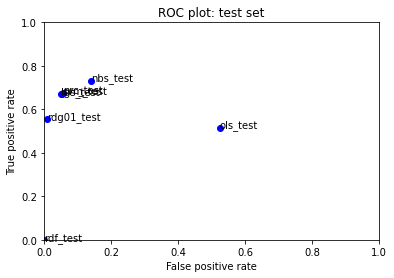

In [142]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg01_performance_test, rdf_performance_test]

#fits = [rdg01_performance_test,rdg02_performance_test,rdg03_performance_test,rdg04_performance_test,rdg05_performance_test]
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Comparison plots for various models

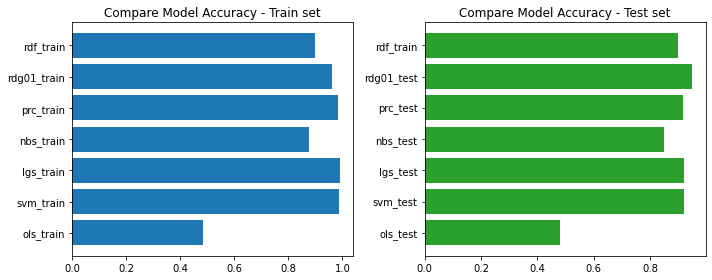

In [143]:
fits = [ols_performance_train, svm_performance_train, 
        lgs_performance_train, nbs_performance_train, prc_performance_train, rdg01_performance_train, rdf_performance_train]
fits2 = [ols_performance_test, svm_performance_test, 
        lgs_performance_test, nbs_performance_test, prc_performance_test, rdg01_performance_test, rdf_performance_train]

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
for fit in fits:
    plt.barh(fit.desc, fit.performance_measures['Accuracy'], color=['tab:blue'])
    plt.title('Compare Model Accuracy - Train set')

plt.subplot(1, 2, 2)
for fit in fits2:
    plt.barh(fit.desc, fit.performance_measures['Accuracy'], color=['tab:green'])
    plt.title('Compare Model Accuracy - Test set')
    
plt.tight_layout()
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 189775)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48613904050560186


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,True
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation